# Horizontal Integration Tutorial for ST and SM Data

This tutorial demonstrates the process of horizontally integrating spatial transcriptomics (ST) and spatial metabolomics (SM) data using spatialMETA. Horizontal integration is a powerful technique to address batch effects.

In [3]:
import spatialmeta as smt
from spatialmeta.model import AlignmentVAE
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt

In [4]:
RCC_sample_list = ["R114_T","S15_T","X49_T","Y27_T","Y7_T"]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Read and preprocess data

### Read and merge data

In this step, we read and merge the ST and SM data for each sample. 

In [8]:
for i in RCC_sample_list:
    adata_SM_name_new = "adata_SM_"+i+"_new"
    adata_ST_name_new = "adata_ST_"+i+"_new"
    adata_ST_new = sc.read_h5ad("./spatialmeta_tutorial/data/ccRCC_samples/adata_ST_"+i+"_new.h5ad")
    adata_SM_new = sc.read_h5ad("./spatialmeta_tutorial/data/ccRCC_samples/adata_SM_"+i+"_new.h5ad")
    globals()[adata_SM_name_new] = adata_SM_new
    globals()[adata_ST_name_new] = adata_ST_new

In [10]:
for i in RCC_sample_list:
    adata_SM_name_new = "adata_SM_"+i+"_new"
    adata_ST_name_new = "adata_ST_"+i+"_new"
    adata_SM_new = globals()[adata_SM_name_new]
    adata_ST_new = globals()[adata_ST_name_new]
    joint_adata = smt.pp.joint_adata_sm_st(
        adata_SM_new=adata_SM_new,
        adata_ST_new=adata_ST_new
    )
    joint_adata_name = "joint_adata_" +i 
    globals()[joint_adata_name] = joint_adata

/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1

In [11]:
merge_adata = anndata.concat({
"R114_T":joint_adata_R114_T,
"S15_T":joint_adata_S15_T,
"X49_T":joint_adata_X49_T,
"Y27_T":joint_adata_Y27_T,
"Y7_T":joint_adata_Y7_T,
},label="sample")

/home/rolan/miniconda3/envs/spatialtk/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
merge_adata.var = joint_adata_Y7_T.var

In [13]:
merge_adata

AnnData object with n_obs × n_vars = 20038 × 37703
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample'
    var: 'name', 'type'
    obsm: 'spatial'

### Normalize merge data

In this step, we normalize the merged data.

In [14]:
merge_adata.layers["counts"] = merge_adata.X.copy()

In [15]:
smt.pp.normalize_total_joint_adata_sm_st(merge_adata,
                         target_sum_SM=1e4,
                         target_sum_ST=1e4)

In [16]:
merge_adata.layers["normalized"] = merge_adata.X.copy()

In [17]:
merge_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge.h5ad")

### Quality control

We perform quality control to remove low-quality spots.

In [27]:
merge_adata = merge_adata[merge_adata.obs['total_intensity']>=1e5]

In [28]:
merge_adata = merge_adata[merge_adata.obs['total_counts']<=40000]

### Calculate SVGs/SVMs and remove batch-baised SVGs/SVMs

We also calculate spatial variable genes/metabolites(SVGs/SVMs) to identify features that exhibit spatial variation. In addition, we remove those that are batch-biased.

In [29]:
smt.pp.spatial_variable_joint_adata_sm_st(
    merge_adata,
    n_top_genes = 2500,
    n_top_metabolites = 1000,
    batch_key="sample",
    min_samples = 3,
    min_frac = 0.9,
    min_logfc= 3,
)

In [30]:
merge_data = merge_adata[:,merge_adata.var.highly_variable_moranI]

In [31]:
merge_data

View of AnnData object with n_obs × n_vars = 19860 × 2841
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample'
    var: 'name', 'type', 'highly_variable_moranI'
    obsm: 'spatial'
    layers: 'counts', 'normalized'

In [32]:
merge_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_hvf.h5ad")

## ConditionalVAE for horizontal integration for ST and SM

In this step, we perform horizontal integration using the ConditionalVAE model.

In [33]:
merge_adata.X = merge_adata.layers["counts"]

In [35]:
smt.pp.normalize_total_joint_adata_sm_st(
    merge_adata,
    target_sum_SM=1e3,
    target_sum_ST=None
)

In [36]:
model = smt.model.ConditionalVAE(
    merge_adata,
    n_latent=10,
    device='cuda:0',
    batch_keys= ["sample"],
    batch_embedding="embedding"
)

In [37]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    kl_loss_reduction= 'mean',
    mode='multi'
)

/home/rolan/Documents/spatialMETA/spatialmeta/util/logger.py:151: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm_notebook
Epoch 64: 100%|██████████| 64/64 [03:24<00:00,  3.20s/it, reconst_sm=-2.35e+03, reconst_st=6.00e+03, kldiv=2.73e+


### Loss visualization

In [38]:
loss_df = pd.DataFrame(loss_dict)

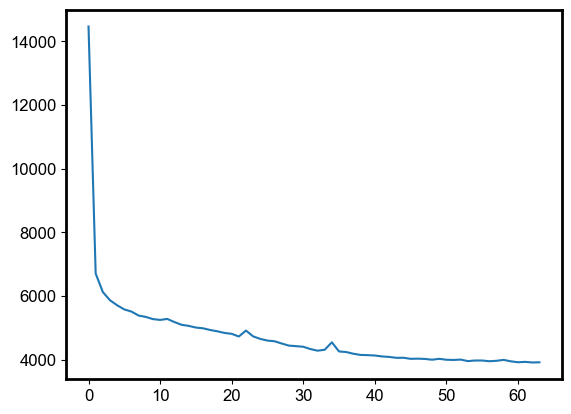

In [40]:
plt.plot(loss_df.index,
         loss_df.epoch_total_loss_list,
         label='epoch_total_loss_list'
) 

### Visualization and analysis

In [41]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()

Latent Embedding: 100%|██████████| 156/156 [00:03<00:00, 44.47it/s]                                              


In [42]:
merge_adata.layers['reconstruction'] = X
merge_adata.obsm['X_emb']=Z

In [9]:
sc.pp.neighbors(merge_adata,
                use_rep="X_emb",
                n_neighbors=20)

In [10]:
sc.tl.umap(merge_adata,spread=3)

In [11]:
sc.tl.leiden(merge_adata, 
             resolution= 1,
             key_added="VAE_clusters_latent10")

<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

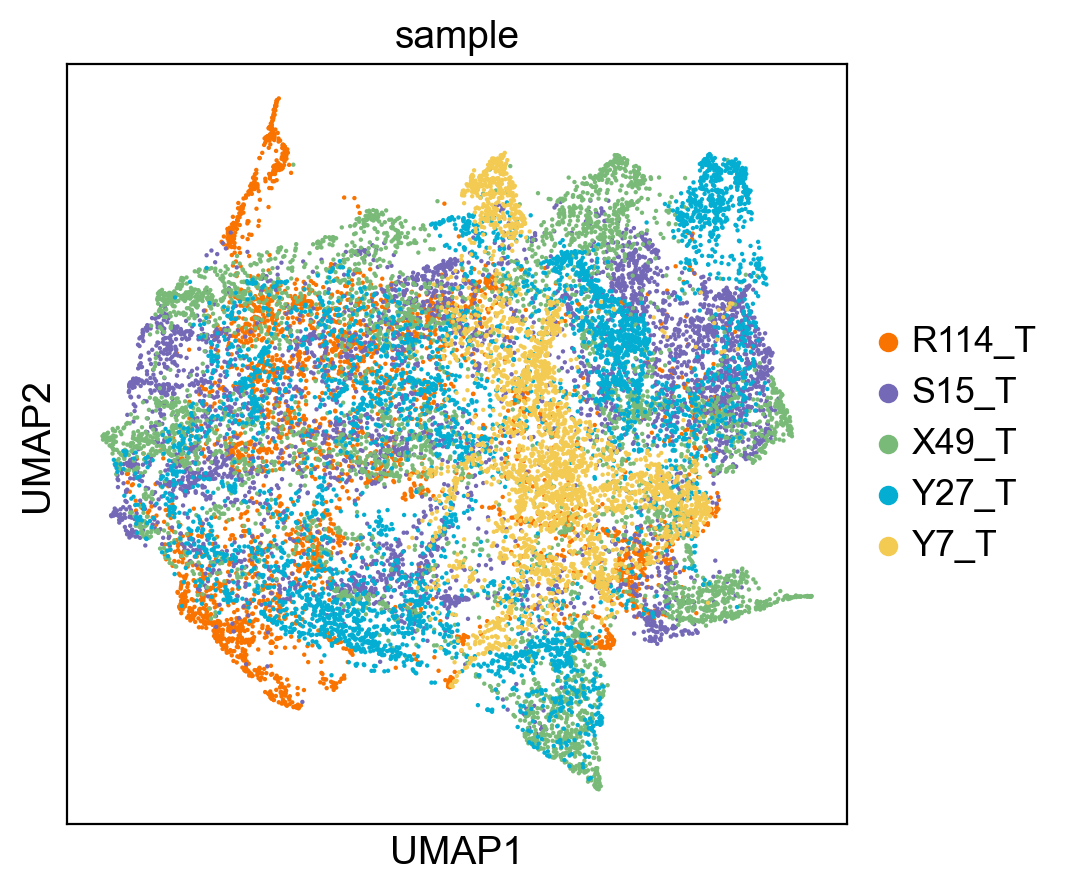

In [7]:
sc.settings.set_figure_params(dpi=100, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           color=["sample"],
           palette = {
              "R114_T": "#F97300",
              "S15_T": "#7469B6",
              "X49_T": "#7ABA78",
              "Y27_T": "#03AED2",
              "Y7_T": "#F3CA52",
           },
           show = False,
           size = 10,
           ax=ax
)

<Axes: title={'center': 'VAE_clusters_latent10'}, xlabel='UMAP1', ylabel='UMAP2'>

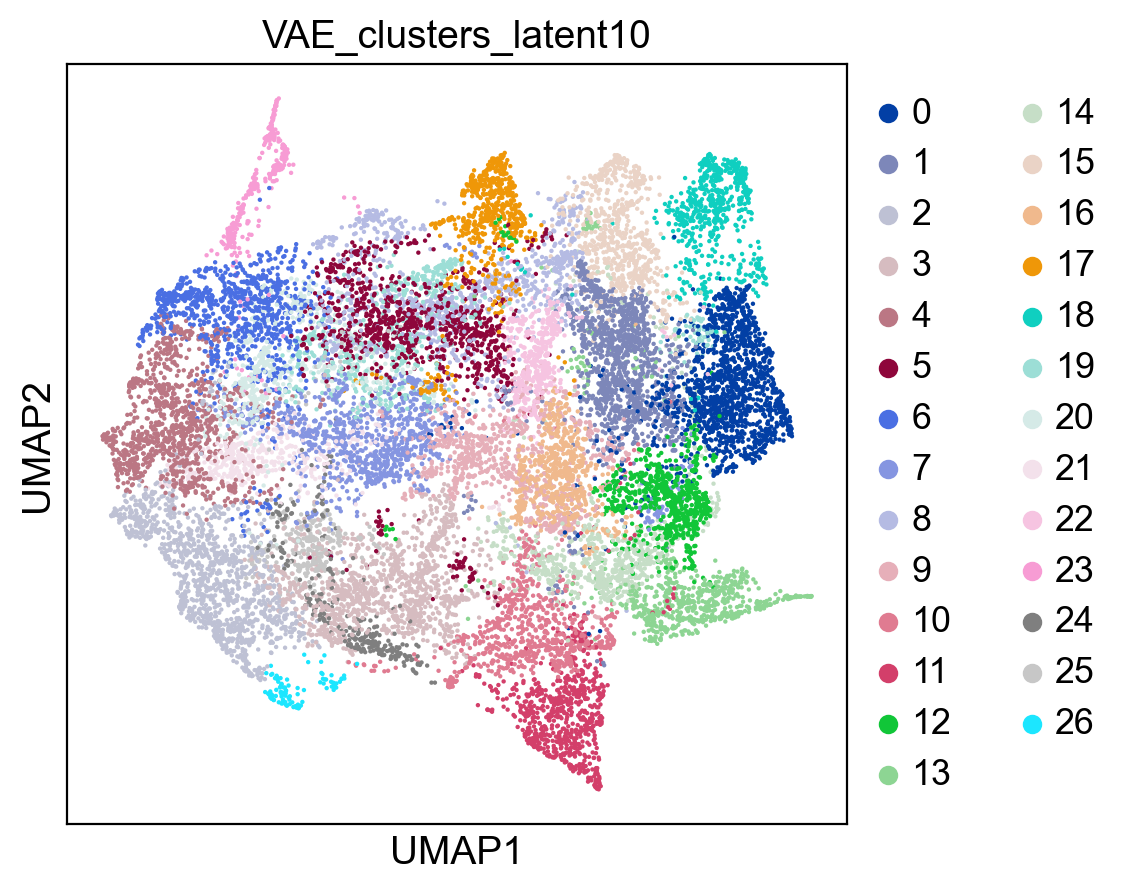

In [8]:
sc.settings.set_figure_params(dpi=100, facecolor="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           color=["VAE_clusters_latent10"],
           palette = sc.pl.palettes.default_28,
           show = False,
           size = 10,
           ax=ax
)

In [54]:
merge_adata.write_h5ad("./spatialmeta_tutorial/data/ccRCC_merge_hvf_afterVAE.h5ad")